In [1]:
import os
import sys
notebook_dir = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

from app.segment_geospatial.predict import SegmentationPredictor
import os
import leafmap

2025-01-25 16:24:39.393 | INFO     | app.segment_geospatial.predict:__new__:37 - Initializing LangSAM model...


final text_encoder_type: bert-base-uncased


2025-01-25 16:24:44.931 | SUCCESS  | app.segment_geospatial.predict:__new__:39 - LangSAM model initialized successfully


In [2]:
sam_model = SegmentationPredictor()

In [3]:
request_data = {
  "bounding_box": [
    -96.77738159894946,
    32.78197733203472,
    -96.77620947360994,
    32.78268991937202
  ],
  "text_prompt": "car",
  "zoom_level": 19
}

image = "satellite_1.tif"
bounding_box = request_data["bounding_box"]
zoom_level = request_data["zoom_level"]
text_prompt = request_data["text_prompt"]

In [4]:

sam_model.download_satellite_image(image_name=image, bounding_box=bounding_box, zoom_level=zoom_level)

satellite_1.tif [-96.77738159894946, 32.78197733203472, -96.77620947360994, 32.78268991937202] 19
Downloaded image 1/9
Downloaded image 2/9
Downloaded image 3/9
Downloaded image 4/9
Downloaded image 5/9
Downloaded image 6/9
Downloaded image 7/9
Downloaded image 8/9
Downloaded image 9/9
Saving GeoTIFF. Please wait...
Image saved to satellite_1.tif


In [5]:
m = leafmap.Map(center=[ 32.78197733203472, -96.77738159894946], zoom=18, height="800px")
m.add_basemap("SATELLITE")

In [6]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Map(center=[32.7823335, -96.77679549999999], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

In [8]:
sam_model.sam.predict(
                    image, 
                    text_prompt, 
                    0.24,  # box_threshold 
                    0.24   # text_threshold
                )

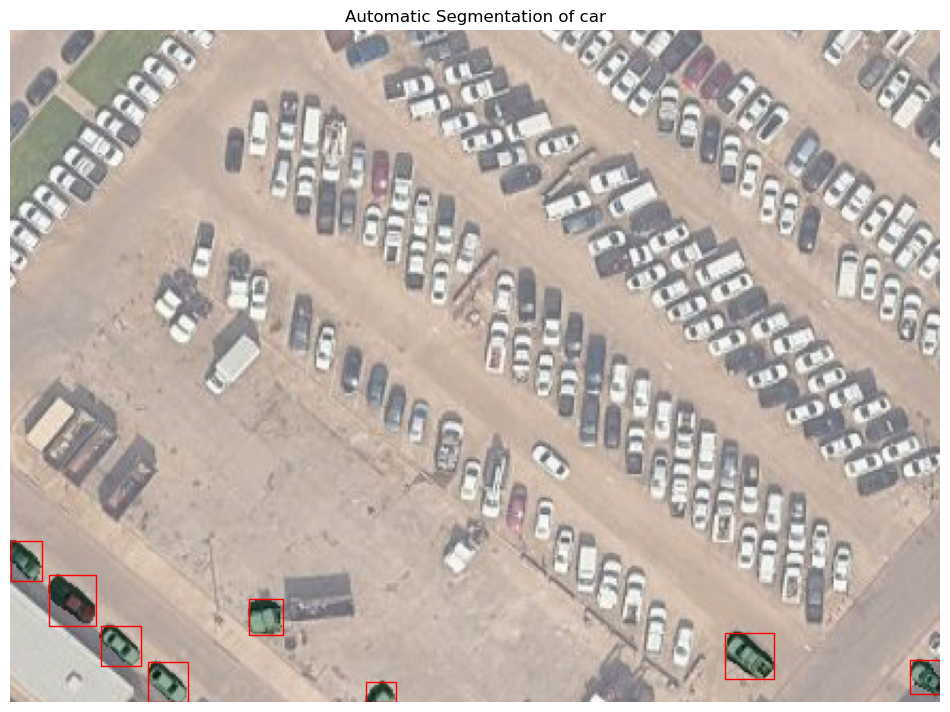

In [10]:
sam_model.sam.show_anns(
    cmap="Greens",
    box_color="red",
    title=f"Automatic Segmentation of {text_prompt}",
    blend=True,
)